# HW5

Miembros del grupo:
- Pablo Carmona
- Javier Sendra

In [1]:
! pip install seaborn

In [2]:
! pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read data

In [2]:
df = pd.read_csv('prosperLoanData_train.csv')
df_oot = pd.read_csv('prosperLoanData_oot.csv')

In [3]:
df.groupby('bad').size()

bad
False    22942
True        78
dtype: int64

## Differenciate between usable features and other columns

In [ ]:
! pip install openpyxl

In [6]:
df_columns = pd.read_excel("/workspaces/Credit_risk/Clasificacion_columnas_sol.xlsx")
drop = df_columns.loc[df_columns["Keep/Drop"]=="Drop"]

In [7]:
features = [c for c in df.columns if c not in drop.Column.values]
col_target = 'bad'

In [6]:
features

['BorrowerRate',
 'ListingCategory (numeric)',
 'Occupation',
 'EmploymentStatus',
 'IsBorrowerHomeowner',
 'CurrentlyInGroup',
 'DateCreditPulled',
 'TotalCreditLinespast7years',
 'OpenRevolvingAccounts',
 'DelinquenciesLast7Years',
 'IncomeRange',
 'StatedMonthlyIncome',
 'TotalProsperLoans',
 'ProsperPaymentsLessThanOneMonthLate',
 'ProsperPaymentsOneMonthPlusLate',
 'ProsperPrincipalBorrowed',
 'ProsperPrincipalOutstanding',
 'LoanCurrentDaysDelinquent',
 'LoanFirstDefaultedCycleNumber',
 'LoanMonthsSinceOrigination',
 'LoanOriginationDate',
 'PW',
 'fraud',
 'bad',
 'indeterm',
 'LoanOriginationYear']

## Data exploration

El primer enfoque que le daremos a nuestras variables será el conocer el tipo de variables que son.
- Por una parte, observamos que muchas variables son de tipo *float64*, las cuales serán como **variables numéricas**
- Por otra parte, observamos que otras variables son de tipo *object* o incluso *booleanos*, las cuales serán **variables categóricas**

In [ ]:
df[features].dtypes

Establecemos una disgregación de variables, para ello separemos aquellas variables que sean categóricas de las que sean numéricas y sobre ellas realizaremos un análisis estadístico descriptivo para ir comparándo unas con las otras e intrepetar los resultados estadísticamente más significativos

In [5]:
cat_features = [f for f, b in zip(features, df[features].dtypes == object) if b==True]
num_features = [f for f in features if f not in cat_features]

In [ ]:
df[num_features].describe().transpose()

In [ ]:
df[cat_features].describe().transpose()

### Custom Pandas describing

**TODO 1** Crea una función que cumpla con la funcionalidad descrita en la cabecera de la función desc_num

In [ ]:
def desc_num(df, df_oot):

    results = {}

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        results[col] = {}
        results[col]['Mean'] = df[col].mean()
        results[col]['Median'] = df[col].median()
        results[col]['Minimum'] = df[col].min()
        results[col]['Maximum'] = df[col].max()
        results[col]['25th Percentile (p25)'] = df[col].quantile(0.25)
        results[col]['75th Percentile (p75)'] = df[col].quantile(0.75)
        results[col]['Standard Deviation (std)'] = df[col].std()
        results[col]['Percentage of Missing Values (%na)'] = (df[col].isnull().mean() * 100)
        results[col]['Percentage of Non-Zero Values (%nonzero)'] = (df[col].astype(bool).sum() / len(df) * 100)
        results[col]['Percentage of Unique Values (%unique)'] = (len(df[col].unique()) / len(df) * 100)

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        axs[0].hist(df[col], bins=20, color='blue', alpha=0.7, label='In-Time')
        axs[0].hist(df_oot[col], bins=20, color='red', alpha=0.7, label='Out-of-Time')
        axs[0].set_title('Histogram')
        axs[0].set_xlabel(col)
        axs[0].legend()

        sns.kdeplot(df[col], label='In-Time', shade=True, ax=axs[1])
        sns.kdeplot(df_oot[col], label='Out-of-Time', shade=True, ax=axs[1])
        axs[1].set_title('Stability Plot')
        axs[1].set_xlabel(col)
        axs[1].legend()

        plt.show()

    return results

In [ ]:
#### EJECUTA AQUÍ LA FUNCIÓN desc_num para todas la variables numéricas
results = desc_num(df, df_oot)

# Muestra los resultados
for col, stats in results.items():
    print(f"Results for {col}:")
    for stat, value in stats.items():
        print(f"{stat}: {value}")
    print()

**TODO 2** Crea una función que cumpla con la funcionalidad descrita en la cabecera de la función desc_cat

In [ ]:
from collections import Counter

def desc_cat(df, df_oot, col):
    stats = {}
    
    unique_entries = df[col].nunique()
    
    percentage_unique = (unique_entries / len(df)) * 100
    
    top_entry = df[col].mode().iloc[0]
    
    top_entry_frequency = (df[col] == top_entry).sum() / len(df) * 100
    
    na_rate = df[col].isna().mean() * 100
    
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")
    plt.title(f'Countplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    stats['Unique Entries'] = unique_entries
    stats['% Unique Entries'] = percentage_unique
    stats['Top Frequent Entry'] = top_entry
    stats['Frequency of Top Entry'] = top_entry_frequency
    stats['NA Rate'] = na_rate
    
    return stats

In [ ]:
#### EJECUTA AQUÍ LA FUNCIÓN desc_cat para todas las variable categóricas
for feat in cat_features:
    print(f"Results for {feat}")
    result = desc_cat(df, df_oot, feat)
    print(result)


### Correlation Review

<AxesSubplot:>

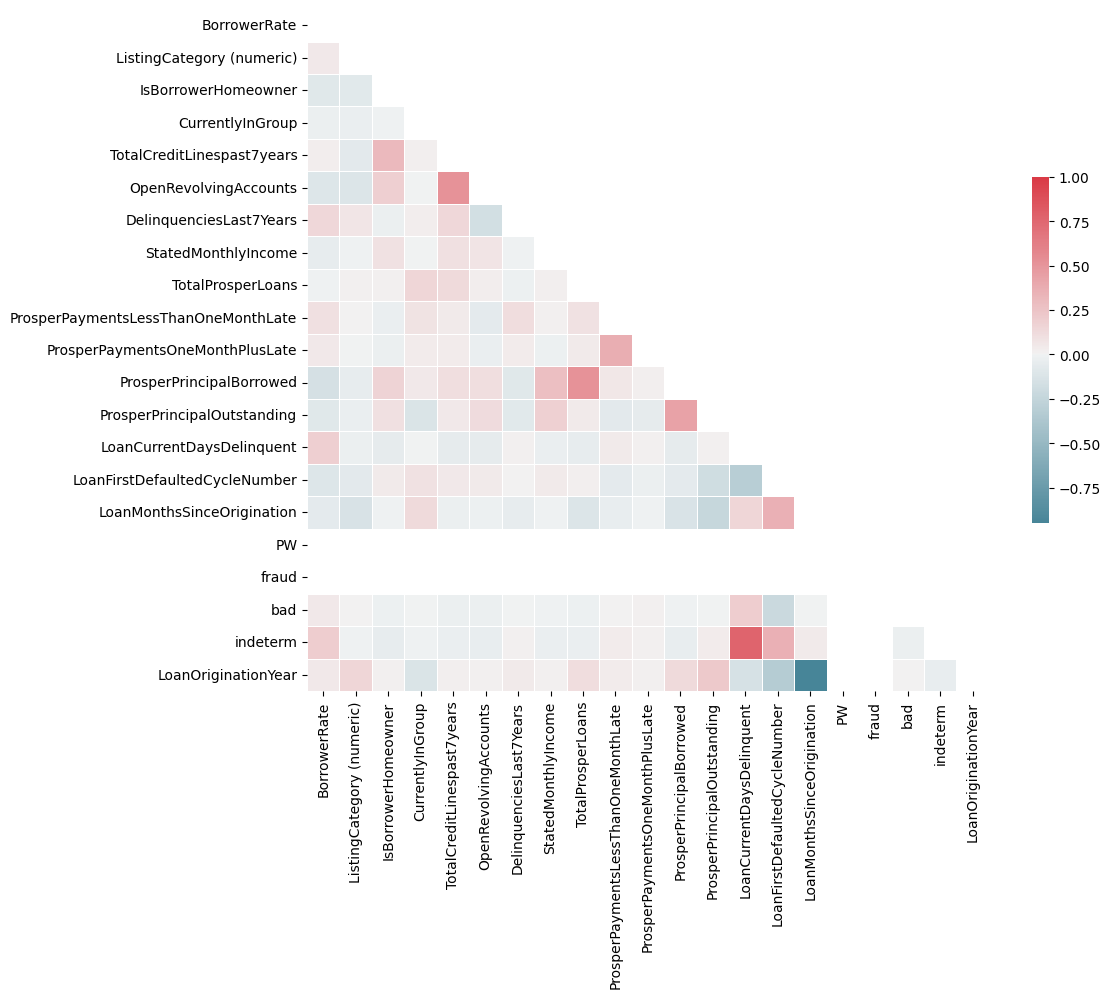

In [9]:
corr = df[num_features].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr[corr!=1].max().sort_values().tail(5)

#### Get pairs of highly correlated features

In [ ]:
corr_TH = 0.75
n_corr_list = []
corr_feats_list = []

In [ ]:
for f in num_features:
    corr_f = corr[f][[col for col in num_features if col!=f]]
    corr_f_abs = corr_f.abs()
    corr_ht_th = corr_f_abs[corr_f_abs>corr_TH]
    n_corr_list.append(corr_ht_th.shape[0])
    corr_feats_list.append(corr_ht_th)
    
corr_relations = [(feat, n, feats_corr) for n, feats_corr, feat in zip(n_corr_list, corr_feats_list, num_features) if n>0]
corr_relations

### Recommended tool: pandas-profiling

In [ ]:
pip install ydata_profiling


In [ ]:
pip install --upgrade matplotlib

In [ ]:
pip install matplotlib==3.4.3

In [ ]:
pip install --upgrade pip

In [ ]:
from pandas_profiling import ProfileReport

# Crea un informe de perfil
profile = ProfileReport(df)

# Genera el informe y guárdalo en un archivo HTML
profile.to_file("/workspaces/Credit_risk/output.html")

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df[features])
profile.to_file(output_file='output.html')

In [ ]:
display(profile)

## IV / WoE


Una vez identificadas las variables más importantes, el siguiente paso que tenemos que hacer es establecer los trameados (buckets), con la misma acción para las variables categóricas y numéricas

In [8]:
#visualization functions
def capture_df(feat_col, input_slider, n_bins, df, target_col):
    """
    Handles the type of the data to generate the intermediate datadframe
    """
    if df[feat_col].dtype in [int, float, np.number]:
        return df_vol_br_num(feat_col, input_slider, n_bins, df, target_col)
    else:
        return df_vol_br_cat(feat_col, input_slider, n_bins, df, target_col)

#capture volume / BR df for numerical variables
def df_vol_br_num(feat_col, input_slider, n_bins, df, obj_col):
    """
    Generate the intermediate dataframe with number of observations and 
    number of bads per bin. Specific for numerical features.
    """
    #get the numeric input from the dual slider
    perc_sliders = [v/100. for v in input_slider]
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[obj_col, feat_col]]
    #number of cuts = minumum of n_bins, number of unique values of the variable
    n_cuts = min(int(n_bins), df_cut[feat_col].nunique())
    cuts = [c for c in np.linspace(v_min, v_max, n_cuts + 1)]
    if cuts[-1] < v_max:
        cuts.append(v_max)
    cut_col = feat_col + '_'
    df_cut[cut_col] = pd.cut(df_cut[feat_col], cuts, include_lowest=True)
    #generate aggregated values
    N = df_cut.groupby(cut_col)[feat_col].count().values
    TR = df_cut.groupby(cut_col)[obj_col].mean().values
    cuts = df_cut.groupby(cut_col)[feat_col].count().index.astype(str).values
    #handle NA entries
    if df[feat_col].isna().sum() > 0:
        N = np.append(([df[feat_col].isna().sum()]), N)
        TR = np.append(([df.loc[df[feat_col].isna()][obj_col].mean()]), TR)
        cuts =  np.append(['NA'], cuts)
    #generate global transformation rate
    return (pd.DataFrame({'cuts': cuts,
                         'N': N,
                         'BR': TR}), df_cut[obj_col].mean())

#capture volume / BR df for categorical variables
def df_vol_br_cat(feat_col, input_slider, n_bins, df, target_col):
    """
    Generate the intermediate dataframe with number of observations and 
    number of bads per bin. Specific for categorical features.
    """
    #pick top n_bins levels by volume
    cut_levels = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    df_cut = df.loc[df[feat_col].isin(cut_levels)]
    #capture volumes
    N = df_cut.groupby(feat_col)[feat_col].count().values
    #capture transformations
    TR = df_cut.groupby(feat_col)[target_col].mean().values
    return (pd.DataFrame({'cuts': df_cut.groupby(feat_col)[feat_col].count().index.astype(str).values,
                         'N': N,
                         'BR': TR}), df_cut[target_col].mean())


def output_graph_update(feat_col, input_slider, n_bins, df, obj_col):
    """
    Generate the plotly plot showing the visualization of the intermediate 
    dataframe with volume and bad rate per bin.
    """
    #get the df with volume and bad rate
    df_tr, avg_tr = capture_df(feat_col, input_slider, n_bins, df, obj_col)
    #line represents transformation rate
    tr_line = go.Scatter(x = df_tr.cuts,
                         y = df_tr.BR,
                         yaxis = 'y2',
                         name = 'BR')
    #bar represents volume @ cut
    vol_bars = go.Bar(x = df_tr.cuts,
                      y = df_tr.N,
                      name = 'Volume')
    #avg line
    avg_line = go.Scatter(x = df_tr.cuts,
                          y = np.repeat(avg_tr, df_tr.shape[0]),
                          yaxis = 'y2',
                          name = 'AVG BR',
                          line = dict(
                              color = ('rgb(205, 0, 0)')
                                     )
                         )
    #small layout
    layout = go.Layout(
            title = 'BR for ' + feat_col,
            yaxis = dict(title = 'Volume',
                         range = [0, max(df_tr.N)]),
            yaxis2 = dict(title = 'BR',
                         overlaying='y',
                         side='right',
                         range = [0, max(df_tr.BR) + 0.05*max(df_tr.BR)])

        )
    return {'data': [vol_bars, tr_line, avg_line],
            'layout': layout}

In [9]:
# Ejemplo de una variable cortada en buckets
df_buckets, avg_ratio = df_vol_br_num('CreditScoreRangeLower', [0, 95], 5, df,'bad')
df_buckets

,cuts,N,BR
0,"(599.999, 640.0]",3691,0.003793
1,"(640.0, 680.0]",6794,0.003827
2,"(680.0, 720.0]",5980,0.004013
3,"(720.0, 760.0]",3872,0.002841
4,"(760.0, 800.0]",2035,0.000491


**TODO 3** Implementa una función que calcule el IV de una variable:

In [10]:
def get_IV(df_buckets, col_vol="N", col_BR="BR"):
    total_IV = 0.0
    for i in range(df_buckets.shape[0]):
        # Calculate the contribution of each bucket to the total IV
        if df_buckets[col_BR].iloc[i] > 0:
            event_pct = df_buckets[col_BR].iloc[i]
        else:
            event_pct = 0.0001  # Avoid division by zero
        non_event_pct = 1 - event_pct
        IV = (non_event_pct - event_pct) * np.log(non_event_pct / event_pct)
        IV = IV * df_buckets[col_vol].iloc[i]
        total_IV += IV
    
    return total_IV

In [11]:
iv = get_IV(df_buckets, col_vol="N", col_BR="BR")
print("IV:", iv)

IV: 128664.48889976504


#### Estimate the IV for all features

In [12]:
ivs = []
for c in features:
    df_tr, avg_br = capture_df(c, [0., 95.], 5, df, 'bad')
    ivs.append(get_IV(df_tr))
df_iv = pd.DataFrame({'feature': features,
                      'IV': ivs}).sort_values(by='IV', ascending=False)
df_iv

/tmp/ipykernel_1343/25389059.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[feat_col].dtype in [int, float, np.number]:
/tmp/ipykernel_1343/25389059.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[feat_col].dtype in [int, float, np.number]:
/tmp/ipykernel_1343/25389059.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[feat_col].dtype in [int, float, np.number]:
/tmp/ipykernel_1343/25389059.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[feat_col].dtype in [int, float, np.number]:
/tmp/ipykernel_1343/25389059.py:6: DeprecationWarnin

,feature,IV
17,InquiriesLast6Months,136632.744195
37,ProsperPaymentsLessThanOneMonthLate,135572.316808
34,TotalProsperLoans,133303.684806
41,ScorexChangeAtTimeOfListing,133215.577586
39,ProsperPrincipalBorrowed,132929.612084
38,ProsperPaymentsOneMonthPlusLate,132619.366165
35,TotalProsperPaymentsBilled,132569.892965
40,ProsperPrincipalOutstanding,132490.981826
36,OnTimeProsperPayments,131907.193844
7,IsBorrowerHomeowner,131381.744563


### Visualize some features versus the Bad rate

In [11]:
#dynamic plotting libraries
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [12]:
df_iv.head()

,feature,IV
23,bad,inf
18,LoanFirstDefaultedCycleNumber,2.041053e+05
17,LoanCurrentDaysDelinquent,1.917570e+05
0,BorrowerRate,1.396439e+05
24,indeterm,1.383933e+05


In [13]:
#plot features
for c in df_iv.sort_values(by="IV", ascending=False).feature.values.tolist():
    py.iplot(output_graph_update(c, [0., 97.5], 6, df, 'bad'))

/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



/tmp/ipykernel_9681/25389059.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



### Stability check - PSI

EL **PSI** es el test de estabilidad de la población. Más sobre el PSI en [esta web](https://mwburke.github.io/data%20science/2018/04/29/population-stability-index.html). El umbral de valores extraídos del PSI se interpreta de la siguiente manera:


- PSI <= 0,10 sin cambios significativos
-  0,10 < PSI <= 0,25 pequeños cambios,  investigar
- PSI > 0,25 cambio significativo

In [24]:
def PSI_numeric(series, in_out_time_series):
    """Returns the population stability index for numerical variables
    
    Args:
        series: Pandas Series, the variable to describe
        in_out_time_series: Pandas Series It contains the in time / out of time series
        
    Returns:
        Estimated PSI
    """
    pd_aux = pd.DataFrame(dict(data = series, in_out = in_out_time_series)).reset_index()
    #capture in time and out of time series
    in_series = pd_aux.loc[pd_aux.in_out == True]['data']
    out_series = pd_aux.loc[pd_aux.in_out == False]['data']

    #base data deciles
    qqs = in_series.quantile(q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    #cut the data, based in the base series deciles
    in_series_cut = pd.cut(in_series, sorted(list(set(qqs.values))), include_lowest=True)
    out_series_cut = pd.cut(out_series, sorted(list(set(qqs.values))), include_lowest=True)
    #count volume per bin
    in_grp = in_series_cut.value_counts(dropna=False)
    out_grp = out_series_cut.value_counts(dropna= not (np.nan in in_grp.index.values.tolist()))
    #small fix, so some inf values are fixed
    out_grp[out_grp==0] = 0.01

    #N observations in each series
    N_in = len(in_series_cut)
    N_out = len(out_series_cut)

    #convert to share in each bin
    in_grp = in_grp / N_in
    out_grp = out_grp / N_out

    return sum((in_grp-out_grp)*np.log(in_grp/out_grp))

def PSI_categorical(series, in_out_time_series):
    """Returns the population stability index for categorical variables
    
    Args:
        series: Pandas Series, the variable to describe
        in_out_time_series: Pandas Series It contains the in time / out of time series
        
    Returns:
        Estimated PSI
    """
    pd_aux = pd.DataFrame(dict(data = series, in_out = in_out_time_series)).reset_index()
    #capture in time and out of time series
    in_series = pd_aux.loc[pd_aux.in_out == True]['data']
    out_series = pd_aux.loc[pd_aux.in_out == False]['data']
    
    #count volume per level
    in_grp = in_series.value_counts(dropna=False)
    out_grp = out_series.value_counts(dropna= not (np.nan in in_grp.index.values.tolist()))
    
    #N observations in each series
    N_in = len(in_series)
    N_out = len(out_series)
    
    #convert to share in each bin
    in_grp = in_grp / N_in
    out_grp = out_grp / N_out
    
    #put all together in a df
    df_grp = in_grp.to_frame().join(out_grp.to_frame(), lsuffix = '_in', rsuffix = '_out')
    df_grp = df_grp.fillna(0.000001)

    return sum((df_grp.count_in - df_grp.count_out) * np.log(df_grp.count_in / df_grp.count_out))

In [25]:
psi = []
#capture in time - out of time series
it_oot_series = pd.Series(np.hstack((np.ones(len(df)), np.zeros(len(df_oot)))))
#for all features

for c in features:
    col_series = pd.concat([df[c], df_oot[c]], ignore_index=True)
    if df[c].dtypes == object:
        psi.append(PSI_categorical(col_series, it_oot_series))
    else:
        psi.append(PSI_numeric(col_series, it_oot_series))

df_psi = pd.DataFrame({'feature': features,
                       'PSI': psi})
df_psi = df_psi.sort_values(by='PSI')
df_psi

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

**TODO 4** Selecciona las dos variables más estables, y procesalas con la función "desc_num"

**TODO 5** Selecciona las dos variables menos estables, y procesalas con la función "desc_num"

In [19]:
#save the data, as it will come handy in future work
# Se escribe serializado
import pickle
#build a dictionary and serialize it
dict_dump = {'features': features,
             'corr_data': corr_relations,
             'iv_df': df_iv,
             'psi_df': df_psi}
pickle.dump(dict_dump, open('output_HW5.pkl', 'wb'))

NameError: name 'corr_relations' is not defined